# NLP Musixmatch
## NLP on top 20 lyrics data (athena's big dataframe)
### Cleans lyrics up (tokenizes, lowercases, removes stop words)
### Looks at repetitiveness as function of time
### Looks at bag of words vectors for different decades (including bi and tri grams)

In [1]:
# import things
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
# Import BeautifulSoup into your workspace
from bs4 import BeautifulSoup  
import re
import string
import operator
from __future__ import division
import datetime
import nltk
#nltk.download()  # Download text data sets, including stop words
from nltk.corpus import stopwords # Import the stop word list
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

/Users/stephanie/anaconda3/envs/snakes/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
#read df from pickle file -- use Athena's large file
d = pd.read_pickle('Lyrics_1950-01-01-2015-01-01MaxRank20')
d.head(3)
#read df from pickle file
hot100 = pd.read_pickle('./Billboard100DF')

In [3]:
#remind ourselves of what the column headers are
print 'fields in lyrics data:', list(d.columns.values)
print 'fields in hot100 data:', list(hot100.columns.values)

fields in lyrics data: ['artist string match score', 'artist_name', 'has_lyrics', 'hot100 artist', 'hot100 track', 'lyrics_id', 'track_id', 'track_name', 'track_spotify_id', 'lyrics_copyright', 'lyrics_body', 'publisher_list', 'can_edit', 'writer_list', 'instrumental', 'verified', 'html_tracking_url', 'lyrics_language_description', 'locked', 'restricted', 'explicit', 'updated_time', 'script_tracking_url', 'action_requested', 'pixel_tracking_url', 'lyrics_language']
fields in hot100 data: ['Artist', 'Change', 'LastPos', 'PeakPos', 'Rank', 'SpotifyID', 'SpotifyLink', 'Title', 'Weeks', 'date']


In [4]:
# notice that the 40 lowest match scores are not true matches
d.sort_values('artist string match score').head(40)

,artist string match score,artist_name,has_lyrics,hot100 artist,hot100 track,lyrics_id,track_id,track_name,track_spotify_id,lyrics_copyright,...,html_tracking_url,lyrics_language_description,locked,restricted,explicit,updated_time,script_tracking_url,action_requested,pixel_tracking_url,lyrics_language
54,8.0,Movie Sounds Unlimited,1.0,U2,"Hold Me, Thrill Me, Kiss Me, Kill Me (From ""Ba...",11382008.0,32530705.0,"Hold Me, Thrill Me, Kiss Me, Kill Me (From ""Ba...",20zGKF0WSAfHSI68AEDMJp,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2015-05-13T15:50:01Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
76,8.0,Bobby Sherman,1.0,Miguel Rios,A Song Of Joy (Himno A La Alegria),14484586.0,19367604.0,A Song of Joy (Himno a La Alegria),3jnbG8jIOmqW7fmQKCpuu8,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2016-02-29T20:12:20Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
76,8.0,Bobby Sherman,1.0,Miguel Rios,A Song Of Joy (Himno A La Alegria),14484586.0,19367604.0,A Song of Joy (Himno a La Alegria),3jnbG8jIOmqW7fmQKCpuu8,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2016-02-29T20:12:20Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
51,10.0,"Kanye West feat. Nas, Rakim & KRS-One",1.0,MKTO,Classic,9950885.0,18717029.0,Classic,,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2014-10-28T22:49:33Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
14,11.0,Michael Bolton,1.0,UB40,The Way You Do The Things You Do,8797229.0,88773241.0,The Way You Do the Things You Do,336jTqfdua4mrO8mI5Fiis,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2013-12-16T18:47:50Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
136,11.0,Michael Bolton,1.0,UB40,The Way You Do The Things You Do,8797229.0,88773241.0,The Way You Do the Things You Do,336jTqfdua4mrO8mI5Fiis,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2013-12-16T18:47:50Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
82,11.0,OK Rainbow Thief,1.0,TLC,Creep,11704035.0,50565858.0,Creep,4iCfDbxdluzKVICiZ9vnxR,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2015-07-10T05:33:47Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
1,11.0,OK Rainbow Thief,1.0,TLC,Creep,11704035.0,50565858.0,Creep,4iCfDbxdluzKVICiZ9vnxR,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2015-07-10T05:33:47Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
136,11.0,Michael Bolton,1.0,UB40,The Way You Do The Things You Do,8797229.0,88773241.0,The Way You Do the Things You Do,336jTqfdua4mrO8mI5Fiis,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2013-12-16T18:47:50Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
47,11.0,Good Riddance,1.0,R.E.M.,Stand,1468011.0,11305865.0,Stand,51mC7gjwHg5aijAXHAItLM,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2010-06-29T05:25:11Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m

In [5]:
# convert certain columns to numeric data in billboard 100 df:
hot100['Weeks'] = pd.to_numeric(hot100['Weeks'])
hot100['Rank'] = pd.to_numeric(hot100['Rank'])
hot100['date'] = pd.to_datetime(hot100['date'])

In [15]:
# some clean up we have to do on billboard:
   
mess = 'Do You Know The Way To San Jos\xc3\x83\xc2\x83\xc3\x82\xc2\xa9'
clean = 'Do You Know The Way To San Jose'
hot100.ix[hot100.Title==mess,'Title']=clean
mess = 'Nel Blu Dipinto Di Blu (Volar\xc3\x83\xc2\x83\xc3\x82\xc2\xa9)'
clean = 'Nel Blu Dipinto Di Blu Volar'
hot100.ix[hot100.Title==mess,'Title']=clean
mess = 'Desir\xc3\x83\xc2\x83\xc3\x82\xc2\xa9e'
clean = 'Desire'
hot100.ix[hot100.Title==mess,'Title']=clean

#side note: the neil diamond one should really be "desiree"

In [6]:
# how many unique songs in the hot100 list?
hot100_artist_track = hot100[['Artist','Title']]
print('# rows before de-dup: ', len(hot100_artist_track))
print('# rows after de-dup: ', len(hot100_artist_track.drop_duplicates()))

('# rows before de-dup: ', 302142)
('# rows after de-dup: ', 27382)


In [7]:
# But remember we were only looking at top 20 tracks... how many total top 20 unique tracks?
print 'Songs ini hot100 with rank <= 20'
hot100_artist_track = hot100[['Artist','Title']][hot100['Rank']<21]
print('# rows before de-dup: ', len(hot100_artist_track))
print('# rows after de-dup: ', len(hot100_artist_track.drop_duplicates()))
billboard_unique_count = len(hot100_artist_track.drop_duplicates())

Songs ini hot100 with rank <= 20
('# rows before de-dup: ', 60418)
('# rows after de-dup: ', 7573)


In [8]:
# a lot of the bad matches have spotify ids, should use this info in the future to check the
# billboard hot100 spotify id's before declaring a match?

In [9]:
print('total df # songs = ', len(d))
print('songs with score > 25 = ', len(d[d['artist string match score']>25]))
print('songs with score > 50 = ', len(d[d['artist string match score']>50]))
print('songs with score > 60 = ', len(d[d['artist string match score']>60]))
print('songs with score > 80 = ', len(d[d['artist string match score']>80]))

('total df # songs = ', 8083)
('songs with score > 25 = ', 7958)
('songs with score > 50 = ', 6246)
('songs with score > 60 = ', 5998)
('songs with score > 80 = ', 5627)


In [10]:
# recall on score > 80 is len(hot100_artist_track.drop_duplicates()) /
print 'recall if match score > 80 used as cutoff'
len(d[d['artist string match score']>80])/float(billboard_unique_count)

recall if match score > 80 used as cutoff


0.7430344645450944

(array([   26.,   116.,   690.,   781.,   280.,   255.,   167.,   176.,
          425.,  5167.]),
 array([   8. ,   17.2,   26.4,   35.6,   44.8,   54. ,   63.2,   72.4,
          81.6,   90.8,  100. ]),
 <a list of 10 Patch objects>)

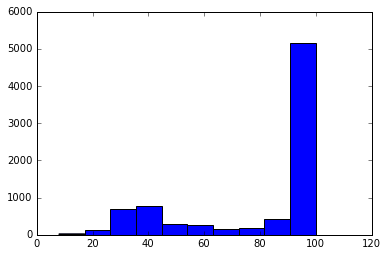

In [11]:
plt.hist(d['artist string match score'])

### The plot above shows that most of out artist string match scores are 90-100, so maybe for higher precision lyrics analysis we should just look at the subset of data greater than 80% accuracy

In [12]:
#check what the >80 look like:
d[d['artist string match score']>80].sort_values('artist string match score').head(40)

,artist string match score,artist_name,has_lyrics,hot100 artist,hot100 track,lyrics_id,track_id,track_name,track_spotify_id,lyrics_copyright,...,html_tracking_url,lyrics_language_description,locked,restricted,explicit,updated_time,script_tracking_url,action_requested,pixel_tracking_url,lyrics_language
116,81.0,John Mellencamp,1.0,John Cougar Mellencamp,Crumblin' Down,7308858.0,31177807.0,Crumblin' Down,2Wh3nUnUTGQ8o3d8ReKUp6,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2012-05-15T01:30:03Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
113,81.0,Michael Martin Murphey,1.0,Michael Murphey,What's Forever For,13115966.0,18795809.0,What's Forever For,7rpLtnDfQTYlYAl2rMdu3v,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2015-12-09T23:33:02Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
61,81.0,Usher feat. Pitbull,1.0,Usher Featuring Pitbull,DJ Got Us Fallin' In Love,13966456.0,73683107.0,DJ Got Us Fallin' in Love,28AUzRo0nQLESL55WDV0um,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2016-01-30T21:34:55Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
100,81.0,Dan Hill feat. Vonda Shepard,1.0,Dan Hill (Duet With Vonda Shepard),Can t We Try,6360223.0,18758480.0,Can't We Try,,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2011-05-31T08:49:37Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
49,81.0,Juvenile & Soulja Slim,1.0,Juvenile Featuring Soulja Slim,Slow Motion,7239133.0,36205743.0,Slow Motion,2v9bQJVXHjrWY2AuIGuWuT,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2012-04-01T21:41:02Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
33,81.0,Tommy Dorsey & his Orchestra,1.0,The Tommy Dorsey Orchestra,Tea For Two Cha Cha,4512160.0,3877439.0,Tea for Two Cha Cha,,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2010-09-05T09:03:57Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
26,81.0,Edward Cochran,1.0,Eddie Cochran,Summertime Blues,8219775.0,17323086.0,Summertime Blues,,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2013-05-27T06:12:53Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
35,81.0,D Mob feat. Cathy Dennis,1.0,D-Mob With Cathy Dennis,C Mon And Get My Love,9704037.0,19263515.0,C'Mon and Get My Love,,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,0,2014-07-17T05:00:52Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
11,81.0,Big Sean feat. E-40,1.0,Big Sean Featuring E-40,I Don't F**k With You,10711385.0,74105312.0,I Don't Fuck With You,7FYH5AW3bVfZHJIQpq3UOA,Lyrics powered by www.musixmatch.com. This Lyr...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,0,1,2015-03-09T08:05:47Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,http://tracking.musixmatch.com/t1.0/m_img/e_1/...,en
36,81.0,Louis Armstrong & His All-Stars,1.0,Louis Armstrong And The All Stars,"Hello, Dolly!",8422670.0,7001265.0,Hello Dolly,7pnGf7VSdGcbHMtuqS5mfs,Unfortunately we're not authorized to show the...,...,http://tracking.musixmatch.com/t1.0/m_html/e_1...,English,0,1,0,2013-09-10T06:46:16Z,http://tracking.musixmatch.com/t1.0/m_js/e_1/s...,,

### Looks like pretty much all of the matches > 80 are true matches

In [13]:
# add a column from the billboard df
d_lyrics = d[d['artist string match score']>80]
d_lyrics = d_lyrics[['hot100 artist','hot100 track','track_name','artist_name','track_spotify_id','lyrics_body']]
d_lyrics.head()

,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body
0,Ricky Nelson,Poor Little Fool,Poor Little Fool,Ricky Nelson,6kGo2CzDxnPP6pxbqABZ7l,I used to play around with hearts\nThat hasten...
2,Bobby Darin,Splish Splash,Splish Splash,Bobby Darin,4RxtXFzUxQCOBAbggjN7mM,"Splish splash, I was taking a bath\nLong about..."
3,Elvis Presley With The Jordanaires,Hard Headed Woman,Hard Headed Woman,Elvis Presley & The Jordanaires,,Well a hard headed woman\nA soft hearted man\n...
6,The Coasters,Yakety Yak,Yakety Yak,The Coasters,3H8EafHcONmawrgbm6DB59,Take out the papers and the trash\nOr you don'...
8,The Johnny Otis Show,Willie And The Hand Jive,Willie and the Hand Jive,The Johnny Otis Show,4aWgjyOJiJNrCGyaueQoVl,I know a cat named Way-Out Willie\nHad a cool ...


In [14]:
d_lyrics[['lyrics_body']].iloc[1].values[0]

u"Splish splash, I was taking a bath\nLong about a Saturday night\nA rub dub, just relaxing in the tub\nThinking everything was alright\n\nWell, I stepped out the tub, put my feet on the floor\nI wrapped the towel around me\nAnd I opened the door, and then\nSplish, splash! I jumped back in the bath\nWell how was I to know there was a party going on\n\nThey was a-splishing and a-splashing, reelin' with the feelin'\n...\n\n******* This Lyrics is NOT for Commercial use *******"

In [16]:
# what is recall on the thing? 
# note there are some duplicate entries in the total df (since we joined multiple years, and some songs are repeated
# from year to year!)
print 'number songs in lyrics database: ',len(d_lyrics)
print 'number UNIQUE: ',len(d_lyrics.drop_duplicates())
# recall on score > 80 
print 'recall :', len(d_lyrics.drop_duplicates())/float(billboard_unique_count)

number songs in lyrics database:  5627
number UNIQUE:  4520
recall : 0.596857256041


## TO DO:
> Fix GetLyrics algorithm to improve recall. Also could get more recall by increasing cutoff (to something lower than 80)

In [17]:
# de-dupe lyrics data:
d_lyrics = d_lyrics.drop_duplicates()
print(len(d_lyrics))

4520


### Let's add a date column to our lyrics dataframe. The block below gets all the dates when the song was in the top 100, and chooses the median date 
> Note: this cell takes a long time to run!

In [19]:
#first add the date column to the lyrics df
d_lyrics['date'] = ""
for i in range(len(d_lyrics)):
    # find corresponding rows in hot100 data frame
    artist = d_lyrics.iloc[i]['hot100 artist']
    track = d_lyrics.iloc[i]['hot100 track']
    #print 'finding rows in hot100 df with artist,track = ', artist, ',', track
    match = hot100[(hot100['Artist']==artist) & (hot100['Title']==track)]
    #print len(match), ' rows found'
    #print match[['Artist','Title','date']]
    datelist = match.date.values
    median_date_index = int(np.floor(len(datelist)/2))
    date_lyrics = datelist[median_date_index]
    d_lyrics['date'].iloc[i]=date_lyrics

In [21]:
d_lyrics.tail(2)

,hot100 artist,hot100 track,track_name,artist_name,track_spotify_id,lyrics_body,date
78,Justin Bieber,Love Yourself,Love Yourself,Justin Bieber,1f8zcJPvJKvxAOjEqM0pyc,For all the times that you rain on my parade\n...,2016-03-25T17:00:00.000000000-0700
79,Ariana Grande,Focus,Focus,Ariana Grande,4r4V1wYecTxSAAXV11cFPD,Hey\n\nI know what I came to do\nAnd that ain'...,2016-01-01T16:00:00.000000000-0800


### Some of the lyrics_body cells are empty due to copyright issues. Let's delete those rows:

In [22]:
#clean d_lyrics up -- if lyrics body is empty, remove it
print 'length d_lyrics before removing empty lyrics body:', len(d_lyrics)
print 'num empty songs:',len(d_lyrics[d_lyrics['lyrics_body']==''])
d_lyrics = d_lyrics[d_lyrics['lyrics_body'] != '']
print 'new length: ', len(d_lyrics)

length d_lyrics before removing empty lyrics body: 4520
num empty songs: 325
new length:  4195


In [24]:
# the recall will decrease a bit:
# recall on score > 80 
print 'recall :', len(d_lyrics)/float(billboard_unique_count)

recall : 0.553941634755


### recall is pretty low, which we can improve on if we search on artist-name first (then fuzzy match track name) (in addition to vice versa), and if we could search by spotify id (but musixmatch docs don't say we can do that, as far as i can see), or maybe also just use the spotify id somehow (if spotify id matches, songs are true match even if string match score is low!)

### for now just use this, work on getting more lyrics w/ better algorithm later!

## Begin Natural Language Processing Stuff!

In [25]:
print('The first lyric body is:')
print(d_lyrics[["lyrics_body"]].iloc[0].values[0])

The first lyric body is:
I used to play around with hearts
That hastened at my call
But when I met that little girl
I knew that I would fall

Poor little fool, oh yeah
I was a fool, uh huh
[(Oh oh, poor little fool)(I was a fool, oh yeah)]

She played around and teased me
With her carefree devil eyes
She'd hold me close and kiss me
But her heart was full of lies

Poor little fool, oh yeah
I was a fool, uh huh
...

******* This Lyrics is NOT for Commercial use *******


In [33]:
# Use regular expressions to do a find-and-replace
example1 = d_lyrics.lyrics_body.iloc[0]
letters_only = re.sub("[^a-zA-Z]",           # The pattern to search for
                      " ",                   # The pattern to replace it with
                      example1 )  # The text to search
print(letters_only)

I used to play around with hearts That hastened at my call But when I met that little girl I knew that I would fall  Poor little fool  oh yeah I was a fool  uh huh   Oh oh  poor little fool  I was a fool  oh yeah    She played around and teased me With her carefree devil eyes She d hold me close and kiss me But her heart was full of lies  Poor little fool  oh yeah I was a fool  uh huh              This Lyrics is NOT for Commercial use        


In [34]:
lower_case = letters_only.lower()        # Convert to lower case
words = lower_case.split()    
words = [str(w) for w in words]
print words

['i', 'used', 'to', 'play', 'around', 'with', 'hearts', 'that', 'hastened', 'at', 'my', 'call', 'but', 'when', 'i', 'met', 'that', 'little', 'girl', 'i', 'knew', 'that', 'i', 'would', 'fall', 'poor', 'little', 'fool', 'oh', 'yeah', 'i', 'was', 'a', 'fool', 'uh', 'huh', 'oh', 'oh', 'poor', 'little', 'fool', 'i', 'was', 'a', 'fool', 'oh', 'yeah', 'she', 'played', 'around', 'and', 'teased', 'me', 'with', 'her', 'carefree', 'devil', 'eyes', 'she', 'd', 'hold', 'me', 'close', 'and', 'kiss', 'me', 'but', 'her', 'heart', 'was', 'full', 'of', 'lies', 'poor', 'little', 'fool', 'oh', 'yeah', 'i', 'was', 'a', 'fool', 'uh', 'huh', 'this', 'lyrics', 'is', 'not', 'for', 'commercial', 'use']


In [35]:
#remove stopwords
# Remove stop words from "words"
words = [w for w in words if not w in stopwords.words("english")]
print(words)

['used', 'play', 'around', 'hearts', 'hastened', 'call', 'met', 'little', 'girl', 'knew', 'would', 'fall', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh', 'oh', 'oh', 'poor', 'little', 'fool', 'fool', 'oh', 'yeah', 'played', 'around', 'teased', 'carefree', 'devil', 'eyes', 'hold', 'close', 'kiss', 'heart', 'full', 'lies', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh', 'lyrics', 'commercial', 'use']


### Note we removed stopwords here, but that might not make sense for the analysis we're interested in. They are listed below. Notice something like "I love you" wouldn't make the cut.

In [37]:
print stopwords.words("english")

[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your', u'yours', u'yourself', u'yourselves', u'he', u'him', u'his', u'himself', u'she', u'her', u'hers', u'herself', u'it', u'its', u'itself', u'they', u'them', u'their', u'theirs', u'themselves', u'what', u'which', u'who', u'whom', u'this', u'that', u'these', u'those', u'am', u'is', u'are', u'was', u'were', u'be', u'been', u'being', u'have', u'has', u'had', u'having', u'do', u'does', u'did', u'doing', u'a', u'an', u'the', u'and', u'but', u'if', u'or', u'because', u'as', u'until', u'while', u'of', u'at', u'by', u'for', u'with', u'about', u'against', u'between', u'into', u'through', u'during', u'before', u'after', u'above', u'below', u'to', u'from', u'up', u'down', u'in', u'out', u'on', u'off', u'over', u'under', u'again', u'further', u'then', u'once', u'here', u'there', u'when', u'where', u'why', u'how', u'all', u'any', u'both', u'each', u'few', u'more', u'most', u'other', u'some', u'such', u'no', u'nor', u

In [38]:
# note the last 3 words should be the same for all lyrics:
print 'last 3 words = lyrics, commercial, use ??'
words[-3:] == ['lyrics', 'commercial', 'use']

last 3 words = lyrics, commercial, use ??


True

In [39]:
#how to remove last 3 words:
words = words[:-3]

In [40]:
def lyrics_to_words( raw_lyrics ):
    # Function to convert a raw review to a string of words
    # The input is a single string (a raw movie review), and 
    # the output is a single string (a preprocessed movie review)
    #
    # 1. Remove HTML
    # lyrics_text = BeautifulSoup(raw_lyrics).get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", raw_lyrics) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()  
    words = [str(w) for w in words] #convert to normal string instead of unicode
    #
    # 4. In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))                  
    # 
    # 5. Remove stop words
    meaningful_words = [w for w in words if not w in stops] 
    assert (meaningful_words[-3:] == ['lyrics', 'commercial', 'use'])
    # remove last 3 words: (all songs should have these as last 3 unless copyright says no)
    meaningful_words = meaningful_words[:-3]
    #
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join( meaningful_words ))   

In [41]:
clean_lyrics = lyrics_to_words( d_lyrics[["lyrics_body"]].iloc[0].values[0] )
print(clean_lyrics)

used play around hearts hastened call met little girl knew would fall poor little fool oh yeah fool uh huh oh oh poor little fool fool oh yeah played around teased carefree devil eyes hold close kiss heart full lies poor little fool oh yeah fool uh huh


In [42]:
clean_lyrics = lyrics_to_words( d_lyrics[["lyrics_body"]].iloc[1].values[0] )
print(clean_lyrics)

splish splash taking bath long saturday night rub dub relaxing tub thinking everything alright well stepped tub put feet floor wrapped towel around opened door splish splash jumped back bath well know party going splishing splashing reelin feelin


In [43]:
num_songs = d_lyrics["lyrics_body"].size
num_songs

4195

### Clean up all the lyrics, store cleaned lyrics as one big list (num_songs length)

In [44]:
# Get the number of reviews based on the dataframe column size
num_songs = d_lyrics["lyrics_body"].size

# Initialize an empty list to hold the clean reviews
clean_lyrics = []
# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
# change xrange to range for python 3
for i in xrange( 0, num_songs ):
    # Call our function for each one, and add the result to the list of
    if( (i+1)%400 == 0 ):
        print("Song %d of %d\n" % ( i+1, num_songs ))  
    # clean lyrics (one for each song)
    clean_lyrics.append( lyrics_to_words( d_lyrics[["lyrics_body"]].iloc[i].values[0] ) )


Song 400 of 4195

Song 800 of 4195

Song 1200 of 4195

Song 1600 of 4195

Song 2000 of 4195

Song 2400 of 4195

Song 2800 of 4195

Song 3200 of 4195

Song 3600 of 4195

Song 4000 of 4195



### Put the cleaned lyrics into our lyrics dataframe (specify no_stopwords in case we want to add another column that includes stopwords

In [45]:
d_lyrics['lyrics_clean_no_stopwords'] = clean_lyrics


In [48]:
# see what happened to a few rows of lyrics, between raw and cleaned
d_lyrics[['lyrics_body','lyrics_clean_no_stopwords']].tail(5)

,lyrics_body,lyrics_clean_no_stopwords
75,I guess for now you've got the last laugh\n\nI...,guess got last laugh sorry seem uninterested l...
76,Take away your things and go\nYou can't take b...,take away things go take back said know heard ...
77,It's a little blurry how the whole thing start...,little blurry whole thing started even really ...
78,For all the times that you rain on my parade\n...,times rain parade clubs get using name think b...
79,Hey\n\nI know what I came to do\nAnd that ain'...,hey know came gonna change go ahead talk talk ...


## How has repetitiveness evolved over time?
> Define lexical diverisity for each song in the database as the number of unique words in that song divided by total number of words in the song. Lower diversity means higher repetitiveness.

In [49]:
# getting an idea of repetition in song lyrics:
test = clean_lyrics[0].split(" ")
print 'words in song:'
print test
print 'unique words in song:'
print set(test)
print 'song has ', len(test), ' words'
print 'but only ', len(set(test)), ' unique words'

# Lexical diversity or density...
# Lexical diversity is something like 
def lexical_diversity(song): 
    words_in_song = song.split(" ")
    return len(set(words_in_song)) / len(words_in_song)

lexical_diversity(clean_lyrics[0])
# note this would maybe be more meaningful if stop words weren't removed!

words in song:
['used', 'play', 'around', 'hearts', 'hastened', 'call', 'met', 'little', 'girl', 'knew', 'would', 'fall', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh', 'oh', 'oh', 'poor', 'little', 'fool', 'fool', 'oh', 'yeah', 'played', 'around', 'teased', 'carefree', 'devil', 'eyes', 'hold', 'close', 'kiss', 'heart', 'full', 'lies', 'poor', 'little', 'fool', 'oh', 'yeah', 'fool', 'uh', 'huh']
unique words in song:
set(['fool', 'played', 'yeah', 'lies', 'full', 'close', 'hastened', 'eyes', 'girl', 'little', 'devil', 'would', 'call', 'poor', 'play', 'used', 'teased', 'around', 'knew', 'huh', 'carefree', 'met', 'kiss', 'fall', 'hold', 'oh', 'heart', 'uh', 'hearts'])
song has  48  words
but only  29  unique words


0.6041666666666666

In [50]:
#test running lexical diversity on the dataframe column values:
lexical_diversity(d_lyrics.lyrics_clean_no_stopwords.iloc[0])

0.6041666666666666

### Calculate lexical diversity for each row in the data frame and
### Add a column for lexical diversity to our data frame

In [51]:
d_lyrics['lex_diversity'] = d_lyrics.lyrics_clean_no_stopwords.map(lexical_diversity)

In [52]:
d_lyrics[['lex_diversity','date']].head(10)

,lex_diversity,date
0,0.604167,1958-09-13T00:00:00.000000000Z
2,0.868421,1958-09-06T00:00:00.000000000Z
3,0.574468,1958-09-06T00:00:00.000000000Z
6,0.962963,1958-08-30T00:00:00.000000000Z
8,0.600000,1958-09-13T00:00:00.000000000Z
12,0.444444,1958-08-30T00:00:00.000000000Z
13,0.760000,1958-09-13T00:00:00.000000000Z
14,0.823529,1958-08-23T00:00:00.000000000Z
15,0.700000,1958-09-06T00:00:00.000000000Z
16,0.843750,1958-08-30T00:00:00.000000000Z


In [53]:
# check how to sort by date..
d_lyrics.sort_values('date').date.values

array([numpy.datetime64('1958-08-23T00:00:00.000000000Z'),
       numpy.datetime64('1958-08-30T00:00:00.000000000Z'),
       numpy.datetime64('1958-08-30T00:00:00.000000000Z'), ...,
       numpy.datetime64('2016-02-12T16:00:00.000000000-0800'),
       numpy.datetime64('2016-03-11T16:00:00.000000000-0800'),
       numpy.datetime64('2016-03-25T17:00:00.000000000-0700')], dtype=object)

### Plot Lexical Diversity as a function of time:

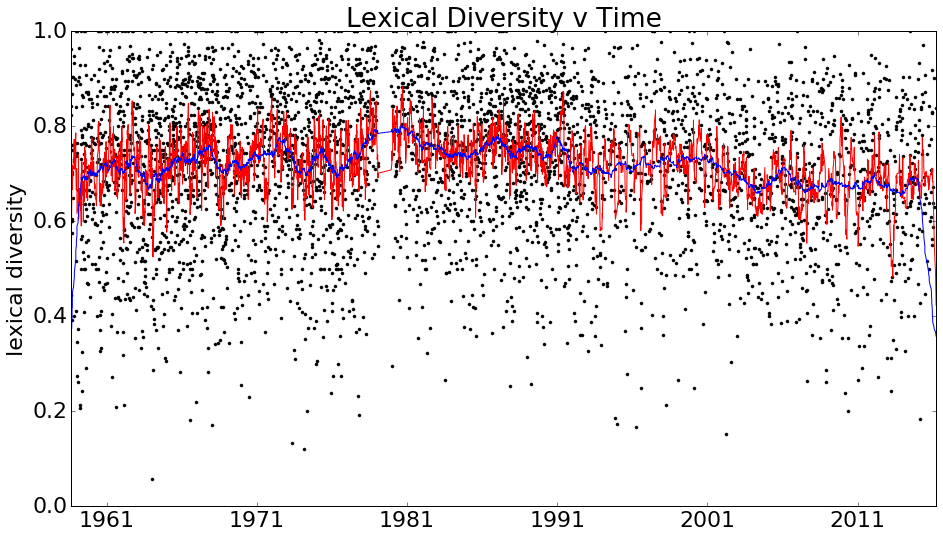

In [54]:
matplotlib.rcParams.update({'font.size': 22})
# what if look at a smoothed time series
#(want to take annual averages as well, but this is easy)
def window(size):
    return np.ones(size)/float(size)
times = d_lyrics.sort_values('date').date.values
vals = d_lyrics.sort_values('date').lex_diversity.values
plt.plot(times,vals,'k.')
plt.plot(times,np.convolve(vals,window(10),'same'),'r')
plt.plot(times,np.convolve(vals,window(100),'same'),'b')

plt.ylabel('lexical diversity')
fig = plt.gcf()
fig.set_size_inches(15.5, 8.5)
plt.title('Lexical Diversity v Time')

### ^^
>Maybe there is a decreasing trend in lexical diversity (increasing repetition) between the 1980s and present day?


## Bag of Words Vectorization:

### The block below makes a bag of words array for each row in the d_lyrics data frame.
### Right now it is working with the column d_lyrics.lyrics_clean_no_stopwords
### In the future we could also have a column that includes stopwords, and we could see how the analysis changes when we include them (e.g. "I love you" might be a common tri-gram)
### ngram_range parameter allows us to include bi-grams and tri-grams if we want to.
### For tfidf:
> transformer = TfidfTransformer()
> tfidf = transformer.fit_transform(word_features)

In [55]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool. 

# Let's make a couple, one with just unigrams, one with just bigrams, 
# one with just tri-grams, and one with all 3
all3_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(1,3)) 

unigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000)
bigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(2,2)) 
trigram_vec = CountVectorizer(analyzer = "word",   \
                             tokenizer = None,    \
                             preprocessor = None, \
                             stop_words = None,   \
                             max_features = 5000, \
                             ngram_range=(3,3)) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
all3_features = all3_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
unigram_features = unigram_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
bigram_features = bigram_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
trigram_features = trigram_vec.fit_transform(d_lyrics.lyrics_clean_no_stopwords).toarray()
# Numpy arrays are easy to work with, so convert the result to an array
# omit the "toarray()" above if you want to preserve sparse format


print('done!')

done!


In [56]:
all3_features

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [57]:
#tfidf weighting -- another way to featurize the words, where rare words are given more weight.
transformer = TfidfTransformer()
tfidf = transformer.fit_transform(all3_features)
tfidf.toarray()

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [67]:
def print_word_counts(vec, feats, n=10):
    # Take a look at the words in the vocabulary
    #n=10 #top 10 words if not input
    vocab = vec.get_feature_names()
    word_features = feats
    # Sum up the counts of each vocabulary word
    dist = np.sum(word_features, axis=0)
    count_dict = dict(zip(vocab, dist))
    #sort dict by counts to see most frequent words
    sorted_count_dict = sorted(count_dict.items(), key=operator.itemgetter(1),reverse=True)
    #look at just the top 50 most frequent features
    print n, ' most frequent features:'
    print sorted_count_dict[:n]
    return sorted_count_dict[:n]

#### Print most common features (when uni- bi- and tri- are included)

In [71]:
foo = print_word_counts(all3_vec, all3_features, 20)

20  most frequent features:
[(u'oh', 462), (u'like', 398), (u'love', 309), (u'know', 306), (u'got', 282), (u'yeah', 282), (u'oh oh', 241), (u'baby', 225), (u'go', 208), (u'let', 207), (u'get', 191), (u'cause', 183), (u'oh oh oh', 166), (u'want', 156), (u'wanna', 144), (u'one', 135), (u'make', 135), (u'back', 135), (u'never', 133), (u'girl', 129)]


#### Print most common bi-grams

In [72]:
foo = print_word_counts(bigram_vec, bigram_features, 20)

20  most frequent features:
[(u'oh oh', 241), (u'yeah yeah', 77), (u'na na', 73), (u'la la', 72), (u'let go', 48), (u'love love', 38), (u'feel like', 29), (u'know know', 27), (u'oh yeah', 27), (u'eh eh', 25), (u'yeah oh', 25), (u'clique clique', 24), (u'da da', 21), (u'hey hey', 21), (u'baby baby', 20), (u'ooh baby', 20), (u'whip hair', 20), (u'back forth', 20), (u'hair back', 19), (u'forth whip', 18)]


#### Print most common tri-grams

In [73]:
foo = print_word_counts(trigram_vec, trigram_features, 20)

20  most frequent features:
[(u'oh oh oh', 166), (u'na na na', 57), (u'la la la', 52), (u'yeah yeah yeah', 51), (u'eh eh eh', 23), (u'yeah oh yeah', 20), (u'whip hair back', 19), (u'hair back forth', 19), (u'back forth whip', 18), (u'clique clique clique', 18), (u'love love love', 17), (u'low go low', 15), (u'oh yeah oh', 15), (u'send call send', 15), (u'go low go', 15), (u'rumour rumour rumour', 14), (u'know know know', 14), (u'call send call', 14), (u'wiggle wiggle wiggle', 14), (u'da da da', 13)]


## How have popular words changed from decade to decade?

In [77]:
# Look at common words across different decades.
d_lyrics['date'] = pd.to_datetime(d_lyrics['date'])
#y = 1970 #decade of interest

for y in [1950, 1960, 1970, 1980, 1990, 2000, 2010]:
    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = d_lyrics[(d_lyrics['date'] > start_date) & (d_lyrics['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    all3_features = all3_vec.fit_transform(lyrics).toarray()
    #unigram_features = unigram_vec.fit_transform(lyrics).toarray()
    #bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    foo = print_word_counts(all3_vec, all3_features)

1950 's
10  most frequent features:
[(u'love', 93), (u'oh', 72), (u'baby', 49), (u'yeah', 45), (u'la', 38), (u'la la', 36), (u'la la la', 35), (u'got', 32), (u'doo', 31), (u'say', 30)]
1960 's
10  most frequent features:
[(u'love', 689), (u'oh', 488), (u'baby', 422), (u'know', 395), (u'yeah', 342), (u'got', 290), (u'like', 255), (u'one', 249), (u'come', 244), (u'see', 244)]
1970 's
10  most frequent features:
[(u'love', 737), (u'got', 410), (u'know', 406), (u'oh', 368), (u'baby', 366), (u'get', 335), (u'like', 312), (u'time', 250), (u'gonna', 226), (u'let', 215)]
1980 's
10  most frequent features:
[(u'love', 902), (u'know', 604), (u'oh', 456), (u'like', 437), (u'baby', 407), (u'got', 399), (u'get', 369), (u'time', 366), (u'yeah', 315), (u'never', 292)]
1990 's
10  most frequent features:
[(u'love', 674), (u'know', 527), (u'like', 502), (u'baby', 483), (u'oh', 348), (u'get', 337), (u'yeah', 314), (u'got', 311), (u'let', 306), (u'never', 300)]
2000 's
10  most frequent features:
[(u'lik

### ^^ Perhaps "Love" has fallen out of fashion

### TO DO : Get the above info in a more usable form, to make a better visualization.

### Below I do the same as above for bigrams, then trigrams...

## How have common bigrams changed from decade to decade?

In [78]:
# Look at common words across different decades.
d_lyrics['date'] = pd.to_datetime(d_lyrics['date'])
#y = 1970 #decade of interest

for y in [1950, 1960, 1970, 1980, 1990, 2000, 2010]:
    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = d_lyrics[(d_lyrics['date'] > start_date) & (d_lyrics['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #unigram_features = unigram_vec.fit_transform(lyrics).toarray()
    #bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    foo = print_word_counts(bigram_vec, bigram_features)

1950 's
10  most frequent features:
[(u'la la', 36), (u'yeah yeah', 26), (u'oh oh', 25), (u'dooby doom', 18), (u'doom dooby', 16), (u'doo doo', 13), (u'bom bom', 12), (u'love love', 10), (u'really mine', 10), (u'bye bye', 9)]
1960 's
10  most frequent features:
[(u'yeah yeah', 126), (u'oh oh', 125), (u'oop oop', 78), (u'la la', 75), (u'hey hey', 53), (u'bird bird', 50), (u'oh yeah', 49), (u'ooh ooh', 47), (u'na na', 45), (u'da da', 40)]
1970 's
10  most frequent features:
[(u'la la', 107), (u'ooh ooh', 77), (u'love love', 67), (u'oh oh', 58), (u'doo doo', 44), (u'yeah yeah', 43), (u'love baby', 38), (u'hey hey', 35), (u'na na', 32), (u'oh baby', 31)]
1980 's
10  most frequent features:
[(u'yeah yeah', 120), (u'oh oh', 112), (u'ooh ooh', 49), (u'let go', 41), (u'boom boom', 34), (u'every time', 32), (u'gonna get', 32), (u'know love', 28), (u'say love', 27), (u'love love', 27)]
1990 's
10  most frequent features:
[(u'oh oh', 92), (u'la la', 71), (u'da da', 70), (u'baby baby', 58), (u'yea

## How have common tri-grams changed from decade to decade?

In [79]:
# Look at common words across different decades.
d_lyrics['date'] = pd.to_datetime(d_lyrics['date'])
#y = 1970 #decade of interest

for y in [1950, 1960, 1970, 1980, 1990, 2000, 2010]:
    print y, '\'s'
    start_date = datetime.date(year=y,month=1,day=1)
    end_date = datetime.date(year=y+10,month=1,day=1)
    subset = d_lyrics[(d_lyrics['date'] > start_date) & (d_lyrics['date'] < end_date) ]
    lyrics = subset.lyrics_clean_no_stopwords
    trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    #unigram_features = unigram_vec.fit_transform(lyrics).toarray()
    #bigram_features = bigram_vec.fit_transform(lyrics).toarray()
    #trigram_features = trigram_vec.fit_transform(lyrics).toarray()
    foo = print_word_counts(trigram_vec, trigram_features)

1950 's
10  most frequent features:
[(u'la la la', 35), (u'yeah yeah yeah', 19), (u'dooby doom dooby', 16), (u'oh oh oh', 12), (u'doom dooby doom', 10), (u'bom bom bom', 9), (u'baby bye bye', 9), (u'bom ba bom', 9), (u'doo doo doo', 8), (u'really mine really', 8)]
1960 's
10  most frequent features:
[(u'yeah yeah yeah', 69), (u'oh oh oh', 62), (u'la la la', 62), (u'oop oop oop', 58), (u'na na na', 37), (u'bird bird bird', 32), (u'da da da', 31), (u'ooh ooh ooh', 25), (u'doo doo doo', 23), (u'um um um', 22)]
1970 's
10  most frequent features:
[(u'la la la', 91), (u'ooh ooh ooh', 53), (u'money money money', 28), (u'love love baby', 27), (u'oh oh oh', 26), (u'na na na', 25), (u'doo doo doo', 25), (u'yeah yeah yeah', 23), (u'baby love love', 20), (u'love baby love', 20)]
1980 's
10  most frequent features:
[(u'oh oh oh', 65), (u'yeah yeah yeah', 65), (u'ooh ooh ooh', 30), (u'na na na', 22), (u'boom boom boom', 17), (u'boom boom acka', 14), (u'shake love shake', 13), (u'love shake love', 1

## Sentiment analysis:
### I've only found good references on supervised sentiment analysis.  If I want to do something unsupervised, maybe I need to make a list of positive words and a list of negative words? Then just label songs based on whether or not they contain positive/negative words. Could also manually label some songs as positive or negative and use those for training.

## TO DO:
### (1) Update analysis to include stop words as well as exclude them
### (2) Split contractions into their root words? 
### (3) Look further into TF-IDF weighting
### (4) Look into stemming words